In [51]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader,random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import PIL

In [6]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [7]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
food101_train=datasets.Food101(root='data',
                               split='train',
                               download=True,
                               transform=train_transform)

food101_test=datasets.Food101(root='data',
                              split='test',
                              download=True,
                              transform=test_transform)

In [9]:
train_size=int(len(food101_train)*0.8)
val_size=len(food101_train)-train_size
generator = torch.Generator().manual_seed(42)
food101_train, food101_val = random_split(food101_train, [train_size, val_size], generator=generator)

In [10]:
food101_train,food101_test,food101_val

(<torch.utils.data.dataset.Subset at 0x14194518910>,
 Dataset Food101
     Number of datapoints: 25250
     Root location: data
     split=test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 <torch.utils.data.dataset.Subset at 0x141e602b890>)

In [11]:
class_names=food101_train.dataset.classes

In [12]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

def unnormalize(tensor, mean, std):  # normlize edilen verileri cizdirirken uyarı almamak için normal boyutuna ceviriyoruz. 0-1 aralığı.
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

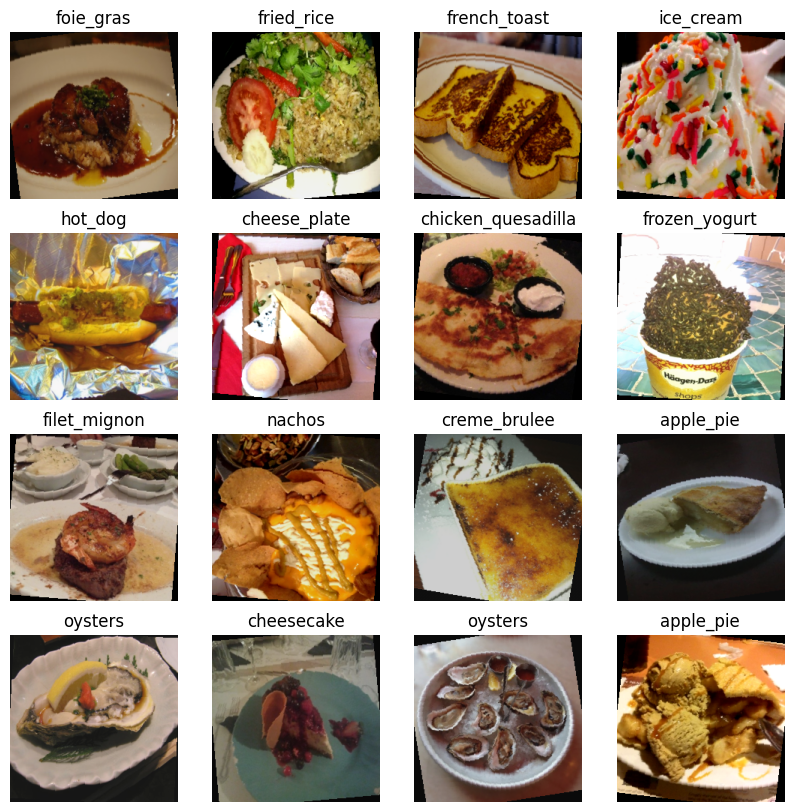

In [13]:
random.seed(81)
rows,cols=4,4
plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
  random_idx=random.randint(1,len(food101_train)+1)
  img,label=food101_train[random_idx]
  plt.subplot(rows,cols,i)
  img=unnormalize(img,mean,std)
  plt.imshow(img.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

In [14]:
train_dataloader=DataLoader(dataset=food101_train,
                            batch_size=32,
                            shuffle=True,
                            num_workers=1)
test_dataloader=DataLoader(dataset=food101_test,
                           batch_size=32,
                           shuffle=False,
                           num_workers=1)
val_dataloader=DataLoader(dataset=food101_val,
                          batch_size=32,
                          shuffle=False,
                          num_workers=1)

train_dataloader,test_dataloader,val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x141979fb790>,
 <torch.utils.data.dataloader.DataLoader at 0x14194c8f950>)

In [15]:
train_features,train_labels=next(iter(train_dataloader)) # dataloaderdan batch batch veri alıyoruz.
train_features.shape,train_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

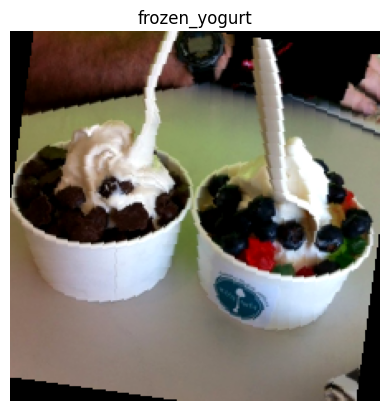

In [16]:
img,label=train_features[0],train_labels[0]
img=unnormalize(img,mean,std)
plt.imshow(img.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [17]:
from torchvision import models

model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
for name, param in model.named_parameters():
    if "layer4" in name:
        param.requires_grad = True

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, len(class_names))
)

model0 = model.to(device)

c:\Users\Yunus\anaconda3\envs\food101_env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Yunus\anaconda3\envs\food101_env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


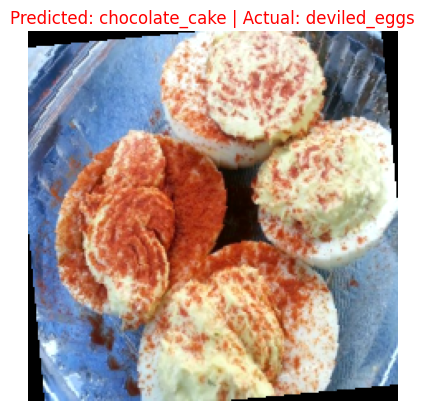

In [18]:
model0.eval()
with torch.inference_mode():
 randm_img,random_label=food101_train[random.randint(1,len(food101_train))]
 predicted=model0(randm_img.unsqueeze(dim=0).to(device))
 pred_class=class_names[torch.argmax(predicted).item()]
 actual_class=class_names[random_label]
 randm_img=unnormalize(randm_img,mean,std)
 plt.imshow(randm_img.permute(1,2,0))
 if pred_class==actual_class:
  plt.title(f'Predicted: {pred_class} | Actual: {actual_class}',c="g")
 else:
  plt.title(f'Predicted: {pred_class} | Actual: {actual_class}',color='red')
 plt.axis(False)

In [19]:
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=correct/len(y_pred)
  return acc

In [20]:
loss_func=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model0.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1) # learning rate scheduler, val loss düşmezse learning rate'i azaltır,böylece model daya iyi yerel min'e ulaşır.

In [21]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
    def __call__(self, val_loss):
      score = -val_loss # loss kücükse -val_loss büyük -> skor büyük,model iyi

      if self.best_score is None:
          self.best_score = score
      elif score < self.best_score + self.min_delta: # yeni skor, en iyi skor ve min deltadan küçükse , yeterince iyi değil sayacı arttır.
          self.counter += 1
          if self.verbose:
              print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
          if self.counter >= self.patience: # art arda patience kadar iyileşmeyen olursa durdur
              self.early_stop = True
      else: # yeni skor önceki skordan iyi veya min delta kadar iyileşmişse
          self.best_score = score
          self.counter = 0

In [22]:
def train_step(model:nn.Module,dataloader:DataLoader,loss_fn:nn.Module,optimizer:torch.optim,device:torch.device,accuracy_fn):
  model.train()
  train_loss,train_acc=0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y=X.to(device),y.to(device)
    y_logits=model(X)
    y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)
    loss=loss_fn(y_logits,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y,y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(dataloader)
  train_acc/=len(dataloader)

  return train_acc,train_loss

In [23]:
def test_step(model:nn.Module,dataloader:DataLoader,loss_fn:nn.Module,optimizer:torch.optim,device:torch.device,accuracy_fn):
  model.eval()
  test_loss,test_acc=0,0
  with torch.inference_mode():
    for X,y in dataloader:
      X,y=X.to(device),y.to(device)
      test_logits=model(X)
      test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
      loss=loss_fn(test_logits,y)
      test_loss+=loss
      test_acc+=accuracy_fn(y_true=y,y_pred=test_pred)

    test_loss/=len(dataloader)
    test_acc/=len(dataloader)
  return test_acc,test_loss

In [24]:
def val_step(model:nn.Module,dataloader:DataLoader,loss_fn:nn.Module,optimizer:torch.optim,device:torch.device,accuracy_fn):
  model.eval()
  val_loss,val_acc=0,0

  with torch.inference_mode():
    for X,y in dataloader:
      X,y=X.to(device),y.to(device)
      val_logits=model(X)
      val_pred=torch.softmax(val_logits,dim=1).argmax(dim=1)
      loss=loss_fn(val_logits,y)
      val_loss+=loss.item()
      val_acc+=accuracy_fn(y,val_pred)
    val_loss/=len(dataloader)
    val_acc/=len(dataloader)

  return val_acc,val_loss

In [25]:
from timeit import default_timer as timer

def train_time(start:float,end:float,device:torch.device):
  total_time=end-start
  print(f'Train time on {device}: {total_time:.3f} seconds')
  return total_time

In [38]:
from tqdm.auto import tqdm

def train(model: nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          val_dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          epochs: int,
          device: torch.device,
          accuracy_fn,
          scheduler=None,
          early_stopping=None):

    results = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in tqdm(range(epochs)):
        train_acc, train_loss = train_step(model0, train_dataloader, loss_fn, optimizer, device, accuracy_fn)
        test_acc, test_loss = test_step(model0, test_dataloader, loss_fn,optimizer, device, accuracy_fn)
        val_acc, val_loss = val_step(model0, val_dataloader, loss_fn,optimizer, device, accuracy_fn)

        print(f"Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
              f"| Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f} "
              f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

        results['train_loss'].append(train_loss.detach().cpu().item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results['train_acc'].append(train_acc.detach().cpu().item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results['test_loss'].append(test_loss.detach().cpu().item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results['test_acc'].append(test_acc.detach().cpu().item() if isinstance(test_acc, torch.Tensor) else test_acc)
        results['val_loss'].append(val_loss.detach().cpu().item() if isinstance(val_loss, torch.Tensor) else val_loss)
        results['val_acc'].append(val_acc.detach().cpu().item() if isinstance(val_acc, torch.Tensor) else val_acc)  

        if scheduler is not None:
            scheduler.step(val_loss)

        if early_stopping is not None:
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print("Early stopping triggered.")
                break

    return results


In [27]:
torch.manual_seed(81)

start_time=timer()
print(f"Training model on device: {next(model0.parameters()).device}")
results=train(model=model0,
              train_dataloader=train_dataloader,
              test_dataloader=test_dataloader,
              val_dataloader=val_dataloader,
              optimizer=optimizer,
              scheduler=scheduler,
              early_stopping=EarlyStopping(patience=3, min_delta=0.001, verbose=True),
              loss_fn=loss_func,
              epochs=10,
              device=device,
              accuracy_fn=accuracy_fn
              )
end_time=timer()
model0_traintime=train_time(start=start_time,end=end_time,device=device)

print(f"Model 0 train time: {model0_traintime:.3f} seconds")

Training model on device: cuda:0


 10%|█         | 1/10 [11:25<1:42:47, 685.27s/it]

Epoch 01 | Train Loss: 2.9314 | Train Acc: 0.3089 | Test Loss: 1.5217 | Test Acc: 0.6038 | Val Loss: 1.8018 | Val Acc: 0.5402


 20%|██        | 2/10 [21:16<1:24:01, 630.17s/it]

Epoch 02 | Train Loss: 1.9190 | Train Acc: 0.5134 | Test Loss: 1.2278 | Test Acc: 0.6708 | Val Loss: 1.5322 | Val Acc: 0.6049


 30%|███       | 3/10 [31:08<1:11:28, 612.69s/it]

Epoch 03 | Train Loss: 1.6173 | Train Acc: 0.5839 | Test Loss: 1.1371 | Test Acc: 0.6969 | Val Loss: 1.4647 | Val Acc: 0.6255


 40%|████      | 4/10 [40:40<59:38, 596.34s/it]  

Epoch 04 | Train Loss: 1.4271 | Train Acc: 0.6271 | Test Loss: 1.0735 | Test Acc: 0.7091 | Val Loss: 1.3948 | Val Acc: 0.6403


 50%|█████     | 5/10 [49:59<48:35, 583.18s/it]

Epoch 05 | Train Loss: 1.2744 | Train Acc: 0.6617 | Test Loss: 1.0411 | Test Acc: 0.7213 | Val Loss: 1.3939 | Val Acc: 0.6432
EarlyStopping counter: 1 out of 3


 60%|██████    | 6/10 [59:44<38:54, 583.62s/it]

Epoch 06 | Train Loss: 1.1475 | Train Acc: 0.6932 | Test Loss: 1.0671 | Test Acc: 0.7145 | Val Loss: 1.3907 | Val Acc: 0.6492


 70%|███████   | 7/10 [1:09:38<29:21, 587.20s/it]

Epoch 07 | Train Loss: 1.0424 | Train Acc: 0.7185 | Test Loss: 1.0239 | Test Acc: 0.7258 | Val Loss: 1.3713 | Val Acc: 0.6592


 80%|████████  | 8/10 [1:19:31<19:37, 588.89s/it]

Epoch 08 | Train Loss: 0.9412 | Train Acc: 0.7422 | Test Loss: 1.0497 | Test Acc: 0.7271 | Val Loss: 1.4003 | Val Acc: 0.6562
EarlyStopping counter: 1 out of 3


 90%|█████████ | 9/10 [1:29:15<09:47, 587.48s/it]

Epoch 09 | Train Loss: 0.8549 | Train Acc: 0.7631 | Test Loss: 1.0814 | Test Acc: 0.7251 | Val Loss: 1.4309 | Val Acc: 0.6603
EarlyStopping counter: 2 out of 3


 90%|█████████ | 9/10 [1:39:01<11:00, 660.13s/it]

Epoch 10 | Train Loss: 0.7773 | Train Acc: 0.7826 | Test Loss: 1.1136 | Test Acc: 0.7239 | Val Loss: 1.4847 | Val Acc: 0.6514
EarlyStopping counter: 3 out of 3
Early stopping triggered.
Train time on cuda: 5941.128 seconds
Model 0 train time: 5941.128 seconds


In [44]:
for k in results:
    results[k] = [x.cpu().item() if isinstance(x, torch.Tensor) else x for x in results[k]]

In [45]:
print(results)

{'train_loss': [2.931365728378296, 1.919021487236023, 1.617288589477539, 1.427072286605835, 1.2744433879852295, 1.147472858428955, 1.0423636436462402, 0.9412264823913574, 0.8548961877822876, 0.7773330211639404], 'train_acc': [0.30893611404435056, 0.513414070749736, 0.5839273143259416, 0.6270954329461457, 0.6617003255895811, 0.6931593189017952, 0.7185300070397747, 0.742234248504048, 0.7631060806054206, 0.7826194561774024], 'test_loss': [1.521685242652893, 1.2277718782424927, 1.137137770652771, 1.0735336542129517, 1.041069746017456, 1.0670794248580933, 1.0238611698150635, 1.049716830253601, 1.08137047290802, 1.1135503053665161], 'test_acc': [0.6037579113924051, 0.6708069620253164, 0.6969145569620253, 0.7090585443037974, 0.7213212025316456, 0.7145174050632911, 0.7257911392405063, 0.7271360759493671, 0.725118670886076, 0.7238924050632911], 'val_loss': [1.8018274859285557, 1.5322019200033277, 1.4647121221330095, 1.3948035559573757, 1.3939141931664591, 1.3906568884849548, 1.371336959773981, 

In [46]:
def plot_loss_curves(results):
  train_losss=results['train_loss']
  test_loss=results['test_loss']
  acc=results['train_acc']
  test_acc=results['test_acc']
  val_loss=results['val_loss']
  val_acc=results['val_acc']

  epochs=range(len(train_losss))
  plt.figure(figsize=(15,7))
  plt.subplot(1,2,1)
  plt.plot(epochs,train_losss,label='train_lossss')
  plt.plot(epochs,test_loss,label='test_loss')
  plt.plot(epochs,val_loss,label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(epochs,acc,label='train_acc')
  plt.plot(epochs,test_acc,label='test_acc')
  plt.plot(epochs,val_acc,label='val_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.show()
  

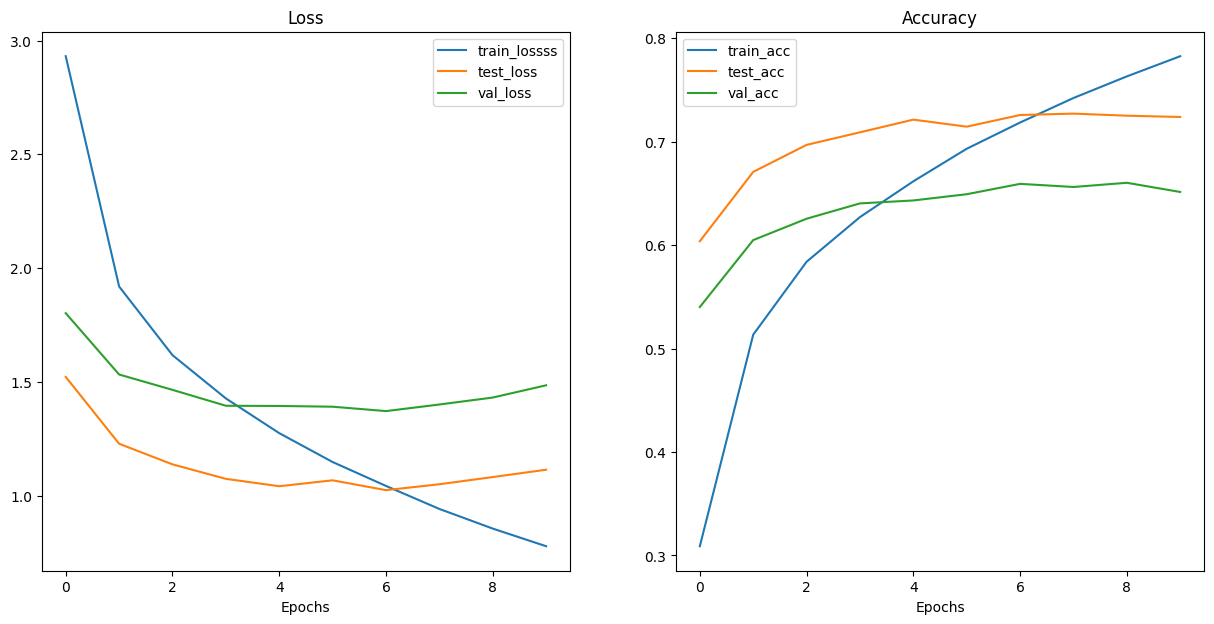

In [47]:
plot_loss_curves(results=results)

In [73]:
from torchvision.io import read_image


def predict_and_plot_image(model: nn.Module,
                           img_path: str,
                           class_names: list[str],
                           device: torch.device,
                           transform: transforms.Compose):

    image = read_image(img_path).type(torch.float32)  / 255.0

    img_vis = image.clone()

    if transform:
        image = transform(image)

    model.to(device)
    model.eval()

    with torch.inference_mode():
        pred_logits = model(image.unsqueeze(0).to(device))
        pred_prob = torch.softmax(pred_logits, dim=1)
        pred_class_idx = pred_prob.argmax(dim=1).item()
        pred_class = class_names[pred_class_idx]

        plt.imshow(img_vis.permute(1, 2, 0))
        plt.axis("off")
        title = f"Pred: {pred_class} | Prob: {pred_prob.max().item():.3f}"
        plt.title(title)
        plt.show()

    return pred_class


In [74]:
img_transform=transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.Resize((224,224))
])

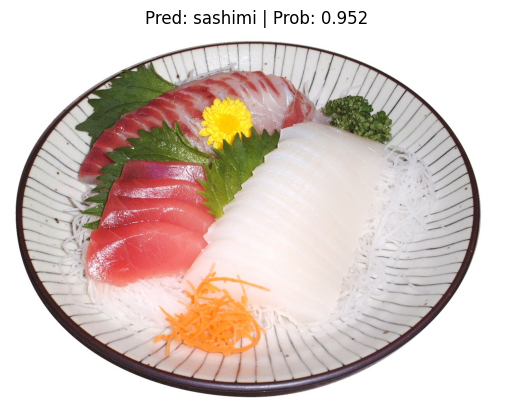

'sashimi'

In [76]:
predict_and_plot_image(model0,"Sashimi.jpg",class_names,device,img_transform)

In [77]:
torch.save(model0.state_dict(),'model0.pth')